# Подготовка окружения

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import AutoTokenizer, pipeline
from torch.utils.data import DataLoader, RandomSampler
from torch.serialization import add_safe_globals
from configs.config import Config
from src.data_utils import process_dataset, split_dataset
from src.next_token_dataset import TextDataset
from src.lstm_model import LSTMModel, count_parameters, generate_samples
from src.lstm_train import train_model
from src.eval_lstm import calculate_rouge_lstm
from src.eval_transformer_pipeline import calculate_rouge_transformer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
IS_TEST = False # тестовый сценарий для отладки кода на слабой машине
config = Config(is_test=IS_TEST) # конфигурационные параметры

tokenizer = AutoTokenizer.from_pretrained(config.tokenizer_name)
tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token

config.pad_token_id = tokenizer.pad_token_id or tokenizer.eos_token_id
config.pad_token = tokenizer.pad_token
config.vocab_size = len(tokenizer)

print(f'вычисления на {config.device}\n')
print('\n параметры запуска')
vars(config)

вычисления на cuda


 параметры запуска


{'raw_ds_path': './data/raw_dataset.txt',
 'ds_processed_path': './data/dataset_processed.txt',
 'ds_train_path': './data/train.csv',
 'ds_val_path': './data/val.csv',
 'ds_test_path': './data/test.csv',
 'model_path': './models/lstm_model.pth',
 'max_raw__ds_length': None,
 'batch_size': 128,
 'embedding_dim': 256,
 'hidden_dim': 128,
 'num_layers': 1,
 'dropout': 0.2,
 'learning_rate': 0.002,
 'num_epochs': 10,
 'max_length': 50,
 'train_val_split': 0.8,
 'val_rouge_samples': 200,
 'text_split_on_prediction': 0.75,
 'device': 'cuda',
 'tokenizer_name': 'distilgpt2',
 'pad_token_id': 50256,
 'pad_token': '<|endoftext|>',
 'vocab_size': 50257}

# Подготовка датасета

### 1. Получение и очистка исходных текстов

In [3]:
file = config.raw_ds_path
if not os.path.exists(file):
    !wget https://code.s3.yandex.net/deep-learning/tweets.txt -O {file}


количество текстов: 1_570_757

статистика количества слов в тексте:
         мин: 2
     медиана: 12.00
     среднее: 12.66
        макс: 58
 5-й перц-ль: 3.00
95-й перц-ль: 25.00


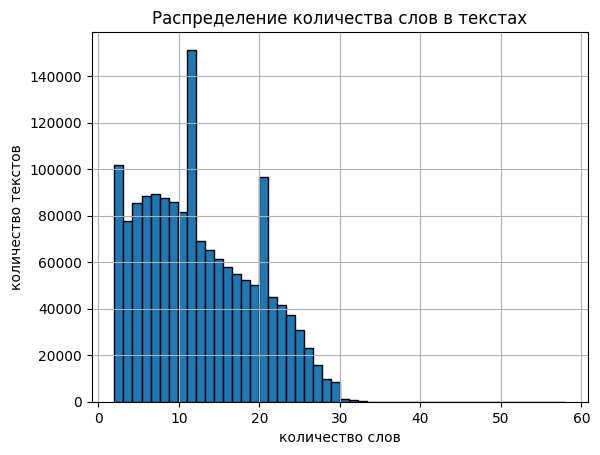


примеры чистых текстов:

www that s a bummer ou shoulda got avid arr of hird ay to do it
is upset that he can t update his acebook by texting it and might cry as a result chool today also lah
dived many times for the ball anaged to save 50 he rest go out of bounds
my whole body feels itchy and like its on fire
no it s not behaving at all i m mad why am i here because can t see you all over there


In [4]:
clean_corpus = process_dataset(config)

### 2. Разделение датасета на подсеты с сохранением в файлы 

In [5]:
train_texts, val_texts, test_texts = split_dataset(texts=clean_corpus,config=config)

# Подготовка Dataloaders

### 1. Инициализация Datasets

In [6]:
train_dataset = TextDataset(train_texts, tokenizer, config)
val_dataset = TextDataset(val_texts, tokenizer, config)
test_dataset = TextDataset(test_texts, tokenizer, config)

print(f'\ntrain_dataset len:', f"{len(train_dataset):_}")
print(f'val_dataset len:  ', f"{len(val_dataset):_}")
print(f'test_dataset len: ', f"{len(test_dataset):_}")


train_dataset len: 1_256_605
val_dataset len:   157_076
test_dataset len:  157_076


### 2. Инициализация Dataloaders

In [7]:
dl_config = {
    'batch_size': config.batch_size,
    'num_workers': 4,
    'pin_memory': config.device=='cuda',
    'persistent_workers': True,
    'prefetch_factor': 2,
}

# подвыборка валидационного сета для расчета rouge на эпохах обучения
val_sampler = RandomSampler(
    val_dataset, 
    replacement=False, 
    num_samples=config.val_rouge_samples   
)

train_dataloader = DataLoader(train_dataset, **dl_config, shuffle=True)
val_dataloader = DataLoader(val_dataset, **dl_config, shuffle=False)
val_sample_dataloader = DataLoader(val_dataset, **dl_config, shuffle=False, sampler=val_sampler)
test_dataloader = DataLoader(test_dataset, **dl_config, shuffle=False)

print(f'батчей в train:    {len(train_dataloader)}')
print(f'батчей в val:      {len(val_dataloader)}')
print(f'батчей в val_smpl: {len(val_sample_dataloader)}')
print(f'батчей в test:     {len(test_dataloader)}')

батчей в train:    9818
батчей в val:      1228
батчей в val_smpl: 2
батчей в test:     1228


# Обучение модели

### Инициализация модели

In [8]:
model = LSTMModel(config)
print('количество параметров: ', f'{count_parameters(model):_}')
model = model.to(config.device)

количество параметров:  19_546_577


In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=config.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

### Обучение и валидация

Модель на cuda:0



         сalc rouge metrics val_smpl: 100%|██████████| 2/2 [00:05<00:00,  2.68s/it, rouge1 max=0.1765]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.76 GB (5.2%)
reserved mem : 1.34 GB
max per epoch: 4.96 GB
=====>GPU 0]

  train loss:      5.6728, val loss: 5.3272
  val_smpl rouge1: 0.0251,   val_smpl rouge2: 0.0006

 -------------------- end of epoch 1/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 2/2 [00:05<00:00,  2.52s/it, rouge1 max=0.1875]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.76 GB (5.2%)
reserved mem : 1.34 GB
max per epoch: 5.14 GB
=====>GPU 0]

  train loss:      5.3517, val loss: 5.2395
  val_smpl rouge1: 0.0263,   val_smpl rouge2: 0.0000

 -------------------- end of epoch 2/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 2/2 [00:05<00:00,  2.56s/it, rouge1 max=0.1579]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.76 GB (5.2%)
reserved mem : 1.34 GB
max per epoch: 5.14 GB
=====>GPU 0]

  train loss:      5.2797, val loss: 5.2073
  val_smpl rouge1: 0.0296,   val_smpl rouge2: 0.0000

 -------------------- end of epoch 3/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it, rouge1 max=0.1935]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.76 GB (5.2%)
reserved mem : 1.34 GB
max per epoch: 5.14 GB
=====>GPU 0]

  train loss:      5.2418, val loss: 5.1910
  val_smpl rouge1: 0.0304,   val_smpl rouge2: 0.0005

 -------------------- end of epoch 4/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 2/2 [00:05<00:00,  2.54s/it, rouge1 max=0.2353]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.76 GB (5.2%)
reserved mem : 1.34 GB
max per epoch: 5.14 GB
=====>GPU 0]

  train loss:      5.2186, val loss: 5.1812
  val_smpl rouge1: 0.0280,   val_smpl rouge2: 0.0014

 -------------------- end of epoch 5/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 2/2 [00:05<00:00,  2.56s/it, rouge1 max=0.2286]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.76 GB (5.2%)
reserved mem : 1.34 GB
max per epoch: 5.14 GB
=====>GPU 0]

  train loss:      5.2014, val loss: 5.1759
  val_smpl rouge1: 0.0225,   val_smpl rouge2: 0.0015

 -------------------- end of epoch 6/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 2/2 [00:05<00:00,  2.56s/it, rouge1 max=0.1818]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.76 GB (5.2%)
reserved mem : 1.34 GB
max per epoch: 5.14 GB
=====>GPU 0]

  train loss:      5.1882, val loss: 5.1709
  val_smpl rouge1: 0.0230,   val_smpl rouge2: 0.0006

 -------------------- end of epoch 7/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 2/2 [00:05<00:00,  2.59s/it, rouge1 max=0.2000]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.76 GB (5.2%)
reserved mem : 1.34 GB
max per epoch: 5.14 GB
=====>GPU 0]

  train loss:      5.1781, val loss: 5.1676
  val_smpl rouge1: 0.0253,   val_smpl rouge2: 0.0005

 -------------------- end of epoch 8/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 2/2 [00:05<00:00,  2.54s/it, rouge1 max=0.1818]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.76 GB (5.2%)
reserved mem : 1.34 GB
max per epoch: 5.14 GB
=====>GPU 0]

  train loss:      5.1690, val loss: 5.1642
  val_smpl rouge1: 0.0243,   val_smpl rouge2: 0.0005

 -------------------- end of epoch 9/10 -------------------- 



         сalc rouge metrics val_smpl: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it, rouge1 max=0.2286]



GPU 0===>:
total mem    : 14.58 GB
!current mem : 0.76 GB (5.2%)
reserved mem : 1.34 GB
max per epoch: 5.14 GB
=====>GPU 0]

  train loss:      5.1617, val loss: 5.1609
  val_smpl rouge1: 0.0312,   val_smpl rouge2: 0.0010

 -------------------- end of epoch 10/10 -------------------- 



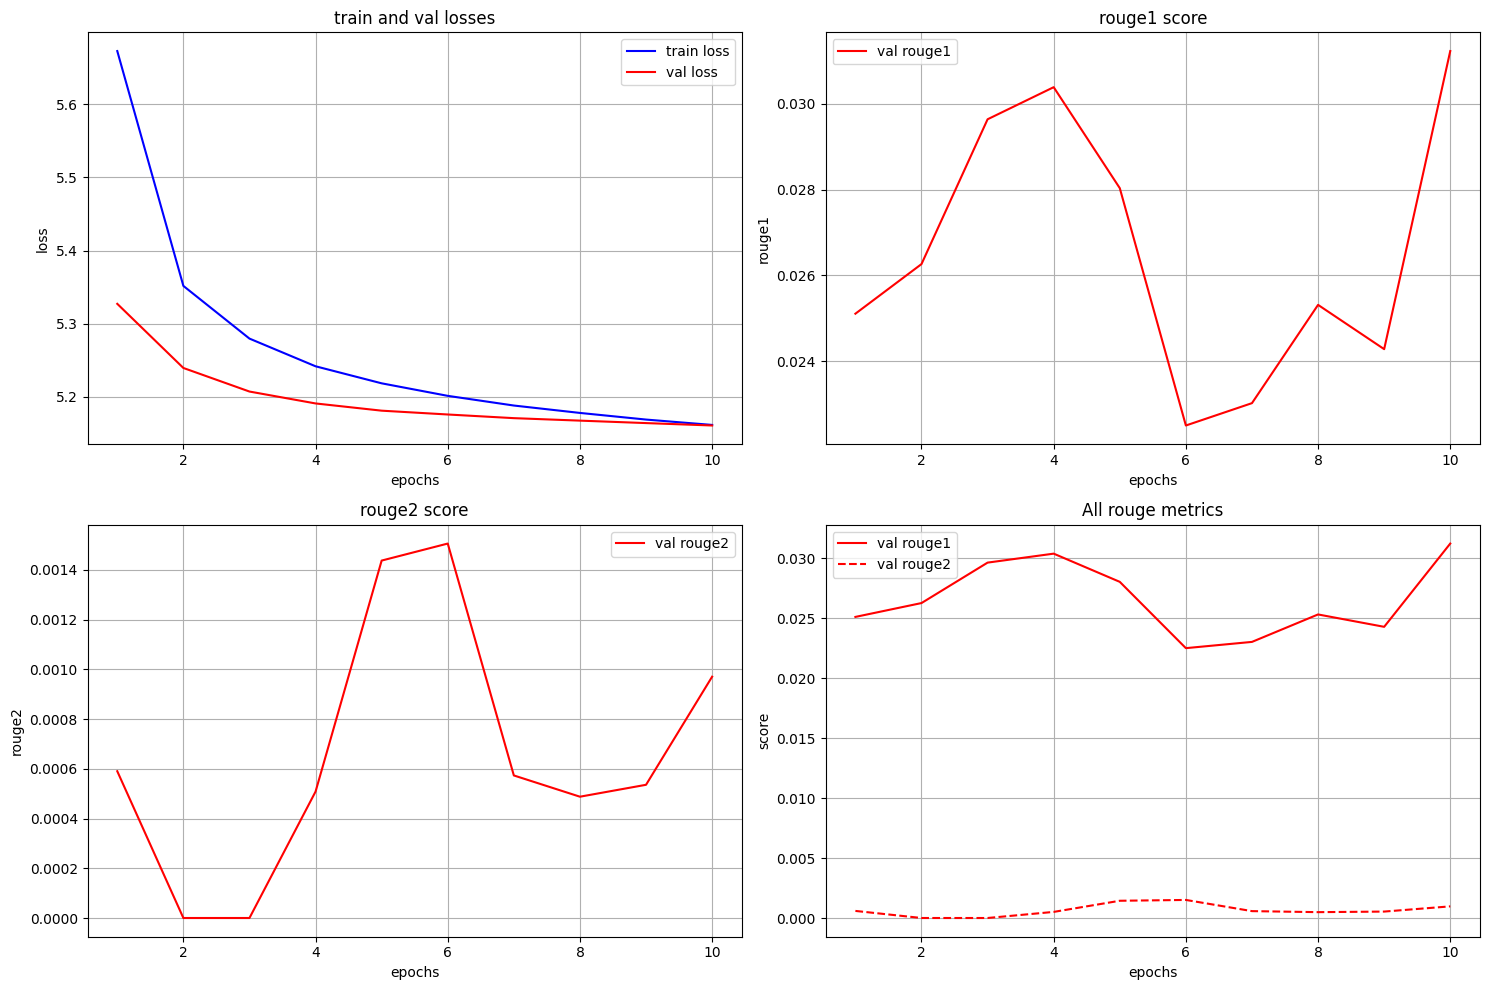

In [10]:
train_model(
    model,
    tokenizer,
    config,
    train_dataloader,
    val_dataloader,
    val_sample_dataloader,
    criterion,
    optimizer,
)

### Сохранение модели

In [11]:
torch.save({
        'model_state_dict': model.state_dict(),
        'config': config,
    }, config.model_path
    )

### Загрузка модели

In [12]:
add_safe_globals([Config])
checkpoint = torch.load(config.model_path, map_location=config.device)
model = LSTMModel(checkpoint["config"]).to(config.device)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

LSTMModel(
  (embedding): Embedding(50257, 256, padding_idx=50256)
  (lstm): LSTM(256, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=50257, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### Генерация дополнения текстов

In [13]:
samples = random.sample(test_texts, 6) # 6 примеров
generate_samples(model, tokenizer, config, samples)

asis:       just took a shower and looked down and realized that have  ->  hairs on my chest
generated:  just took a shower and looked down and realized that have  ->   draws to play peoples mortified hen you say pleased when alter more to remove buttons and regular today ad to open yet another certain things that dont hurt like that great wish i was beta client spammers after lo amp how am on air sports a son
rouge1: 0.0392,   rouge2: 0.0000

asis:       wow just had a two hour conversation with someone on  ->  omegle it was amazing
generated:  wow just had a two hour conversation with someone on  ->   h8y joke in levels here its better ow about amp book today smart hours am helping me mean base saw the show in 3 morning ahh hope you have a safe flight at the end of in line in rench for checking fire ep 1 ant
rouge1: 0.0000,   rouge2: 0.0000

asis:       u a uaska www myspace  ->  com huaska
generated:  u a uaska www myspace  ->   prom 4ga randona ines tarbucks i don t wanna know if c

### Метрики rouge модели на тестовой выборке

In [14]:
print('----модель lstm---------')
print('\nколичество параметров: ', f"{count_parameters(model):_}")
print('\nтекстов в выборке: ', f"{len(test_texts):_}", '\n')

test_dataloader = DataLoader(test_dataset, **dl_config, shuffle=False)

r1, r2 = calculate_rouge_lstm(
    model, test_dataloader, tokenizer, config, prefix="test"
)
print(f"\ntest rouge1: {r1:.4f}, test rouge2: {r2:.4f}")
print('-'*40)

----модель lstm---------

количество параметров:  19_546_577

текстов в выборке:  157_076 



         сalc rouge metrics test: 100%|██████████| 1228/1228 [1:08:25<00:00,  3.34s/it, rouge1 max=0.8421]


test rouge1: 0.0266, test rouge2: 0.0010
----------------------------------------


# Сравнение с трансформером и выводы

### Метрики rouge трансформера на тестовой выборке

In [15]:
print('----модель distilgpt2---------')

tokenizer.padding_side = "left"
generator = pipeline("text-generation", model="distilgpt2", device=config.device, batch_size=config.batch_size, truncation=True, tokenizer=tokenizer)

print('\nколичество параметров: ', f"{count_parameters(generator.model):_}")
print('\nтекстов в выборке: ', f"{len(test_texts):_}", '\n')

r1,r2 = calculate_rouge_transformer(generator, config, test_texts)

print(f"\ntest rouge1: {r1:.4f}, test rouge2: {r2:.4f}")
print('-'*40)

----модель distilgpt2---------


Device set to use cuda



количество параметров:  81_912_576

текстов в выборке:  157_076 



         сalc rouge metrics test: 157076it [09:01, 289.90it/s, rouge1 max=1.0000]



test rouge1: 0.0311, test rouge2: 0.0023
----------------------------------------
